### Import potrzebnych bibliotek

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

### Wczytanie danych

In [35]:
datapath = Path("d:/mw_wedum/wdum") / "data" / "housing"
housing = pd.read_csv(datapath / "housing.csv")
np.random.seed(42)
# housing["ocean_proximity"].value_counts() liczy występowanie w kategorii
# housing.describe() opisuje statystycznie
# housing.describe(include=object)

### Przegląd danych

In [ ]:
housing.head()

In [ ]:
housing["ocean_proximity"].value_counts()

In [ ]:
housing.describe()

In [ ]:
housing.describe(include=object)

### Histogramy danych

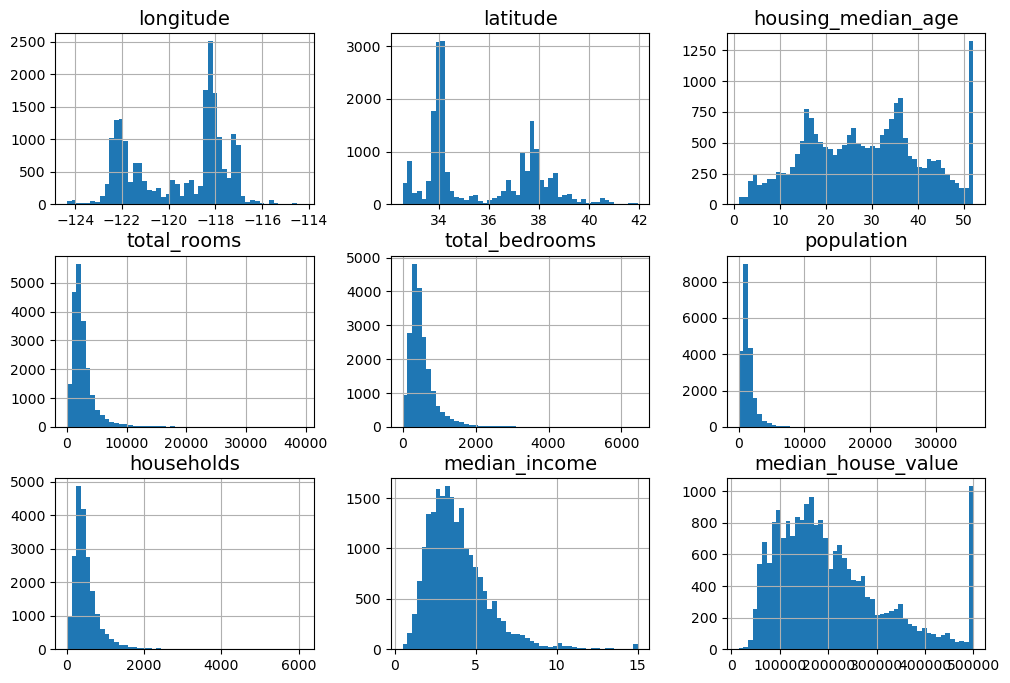

In [36]:
housing.hist(bins=50, figsize=(12, 8)) # pokazują 
plt.show()

### Tworzenie zbioru testowego

#### Tworzenie histogramów przemapowanej kategorii dochodów

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].value_counts()

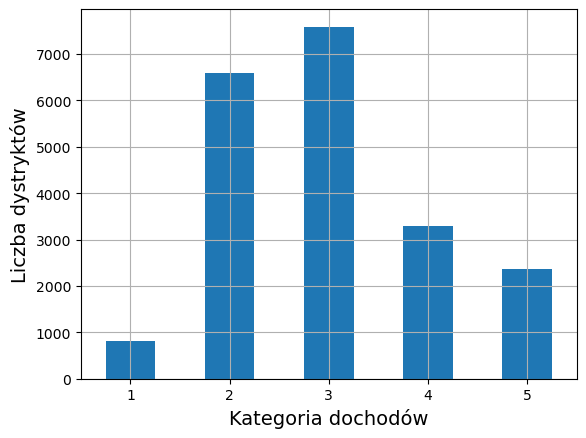

In [54]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Kategoria dochodów")
plt.ylabel("Liczba dystryktów")
plt.show()

#### Tworzenie zbiorów testowych

In [55]:
df_train_rand_samp, df_test_rand_samp = train_test_split(
        housing, test_size=0.2, random_state=42)
df_train, df_test = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"],random_state=42)

#### Porównanie podziałów wewnątrz zbiorów

In [56]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

compare_samp = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(df_test),
    "Random %": income_cat_proportions(df_test_rand_samp),
}).sort_index()
compare_samp.index.name = "Income Category"
compare_samp["Strat. Error %"] = (compare_samp["Stratified %"] /
                                   compare_samp["Overall %"] - 1)
compare_samp["Rand. Error %"] = (compare_samp["Random %"] /
                                  compare_samp["Overall %"] - 1)
(compare_samp * 100).round(2)

for set_ in (df_train, df_test):
    set_.drop("income_cat", axis=1, inplace=True)

### Wizualizacja danych

In [ ]:
for set_ in (df_train, df_test):
    set_.drop("income_cat", axis=1, inplace=True)

##### Bazowy wykres rozkładu geograficznego danych

In [ ]:
df_train_eda = df_train.copy()
df_train_eda.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show() #

##### Wykres punktowy częstotliwości występowania

In [ ]:
df_train_eda.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

##### Wykres punktowy częstotliwości z skalą kolorystyczną

In [ ]:
df_train_eda.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=df_train_eda["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

##### Wykres finalny z nałożoną mapą

In [ ]:
df_train_eda.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=df_train_eda["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(datapath / "california.png")
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)
plt.show()

### Korelacja między zmiennymi

In [61]:
corr_matrix = df_train_eda.select_dtypes(np.number).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688676
total_rooms           0.136368
housing_median_age    0.101696
households            0.067927
total_bedrooms        0.051989
population           -0.024302
longitude            -0.048441
latitude             -0.141664
Name: median_house_value, dtype: float64

#### Scatter chart zmiennych

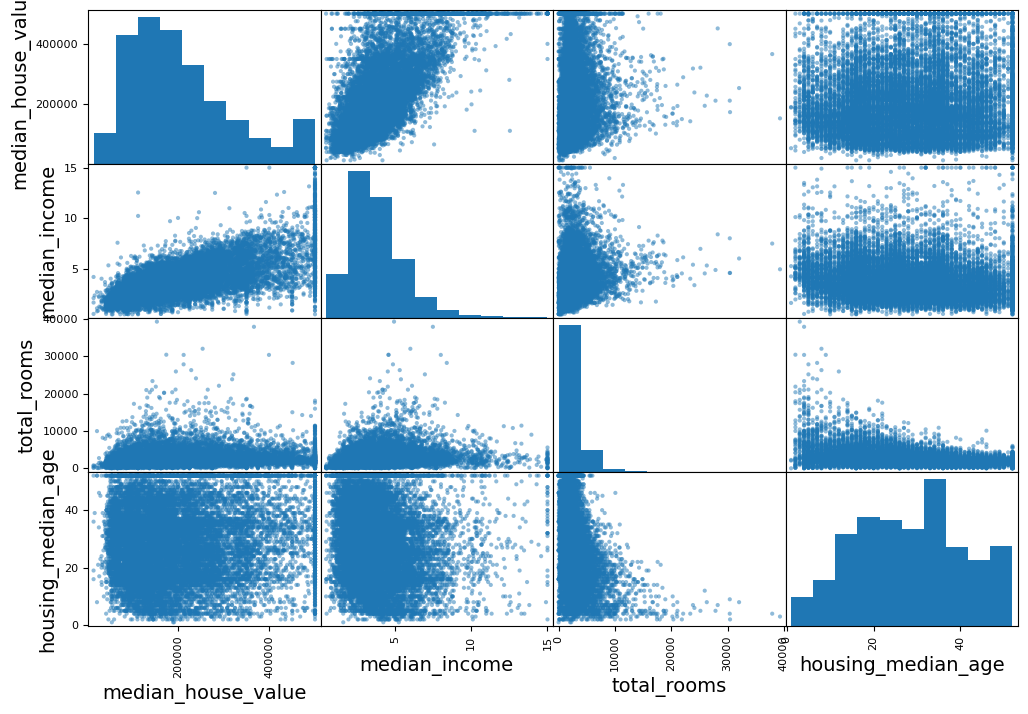

In [62]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(df_train_eda[attributes], figsize=(12, 8))
plt.show()

#### Heatmap chart median_house_value and median_income

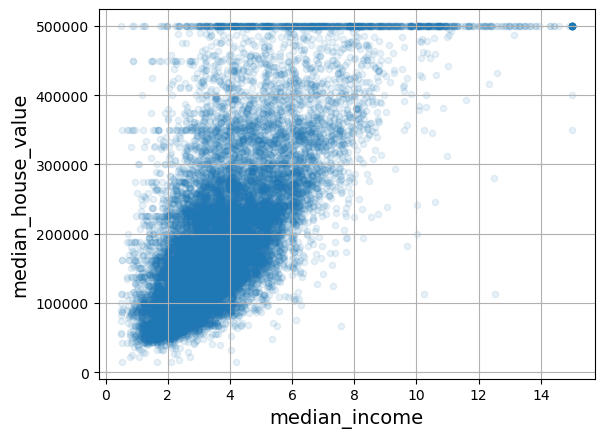

In [75]:
df_train_eda.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
plt.show()

#### Współczynniki korelacji

In [76]:
df_train_eda["rooms_per_house"] = df_train_eda["total_rooms"] / df_train_eda["households"]
df_train_eda["bedrooms_ratio"] = df_train_eda["total_bedrooms"] / df_train_eda["total_rooms"]
df_train_eda["people_per_house"] = df_train_eda["population"] / df_train_eda["households"]

corr_matrix = df_train_eda.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value       1.000000
median_income            0.688676
pokoje_na_rodzinę        0.147148
total_rooms              0.136368
housing_median_age       0.101696
households               0.067927
total_bedrooms           0.051989
population              -0.024302
liczba_osób_na_dom      -0.033336
longitude               -0.048441
latitude                -0.141664
współczynnik_sypialni   -0.257110
Name: median_house_value, dtype: float64

### Uczenie maszynowe

#### Przygotowanie zbiorów do uczenia maszynowego

In [77]:
x_train = df_train.drop("median_house_value", axis=1)
y_train = df_train["median_house_value"].copy()

In [ ]:
df_train.isna().sum() #pokazuje liczbę pustych wartości

#### Usunięcie pustych wartości

In [91]:
null_rows_idx = x_train.isnull().any(axis=1)
x_train.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
16967,-119.32,36.25,21.0,1231.0,433.0,609.0,206.0,2.8365,INLAND
14360,-117.87,33.62,8.0,1266.0,433.0,375.0,183.0,9.8020,<1H OCEAN
5971,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
2348,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
9030,-117.23,32.75,5.0,1824.0,433.0,892.0,426.0,3.4286,NEAR OCEAN


#### Usuniecie całych wierszy

In [ ]:
x_train_option1 = x_train.copy()
x_train_option1.dropna(subset=["total_bedrooms"], inplace=True)  # option 1
x_train_option1.loc[null_rows_idx].head()

#### Usunięcie całej kolumny

In [ ]:
x_train_option2 = x_train.copy()
x_train_option2.drop("total_bedrooms", axis=1, inplace=True)  # option 2
x_train_option2.loc[null_rows_idx].head()

#### Zastąpienie pustych wartości medianą

In [ ]:
x_train_option3 = x_train.copy()
median = x_train["total_bedrooms"].median()
x_train_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3
x_train_option3.loc[null_rows_idx].head()

### Przygotowanie danych do trenowania

In [94]:
imputer = SimpleImputer(strategy="median")
x_train_num = x_train.select_dtypes(include=[np.number])
x_train_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
15636,-117.08,32.62,28.0,2468.0,506.0,1353.0,522.0,3.0771
16805,-115.50,32.75,13.0,330.0,72.0,822.0,64.0,3.4107
19839,-117.79,33.55,39.0,5066.0,1292.0,1915.0,1117.0,3.8210
11848,-119.80,36.78,50.0,1818.0,374.0,737.0,338.0,2.2614
16326,-122.50,38.35,25.0,1566.0,352.0,784.0,362.0,3.0750
...,...,...,...,...,...,...,...,...
5844,-118.40,34.18,32.0,3724.0,899.0,1912.0,791.0,3.5711
15599,-122.35,37.92,36.0,921.0,200.0,585.0,236.0,1.9224
7419,-117.15,32.91,14.0,1259.0,238.0,889.0,247.0,4.9464
2764,-121.47,38.57,39.0,1360.0,368.0,589.0,338.0,2.1691


In [ ]:
imputer.fit(x_train_num)

In [ ]:
imputer.statistics_

In [ ]:
x_train_num.median().values

In [ ]:
X = imputer.transform(x_train_num)

In [ ]:
imputer.feature_names_in_

In [ ]:
x_train_tr = pd.DataFrame(X, columns=x_train_num.columns,
                          index=x_train_num.index)
x_train_tr

In [ ]:
x_train_tr.loc[null_rows_idx].head()

In [ ]:
imputer = SimpleImputer(strategy="median").set_output(transform="pandas")
X = imputer.fit_transform(x_train_num)

X = imputer.transform(x_train_num)
X

In [ ]:
X.loc[null_rows_idx].head()